# General Vs. Material Classification

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Model</a></span></li><li><span><a href="#Freeze-Base-Model" data-toc-modified-id="Freeze-Base-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Freeze Base Model</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Accuracy-&amp;-Loss" data-toc-modified-id="Evaluate-Accuracy-&amp;-Loss-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluate Accuracy &amp; Loss</a></span></li><li><span><a href="#Try-Only-3-Epochs" data-toc-modified-id="Try-Only-3-Epochs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Try Only 3 Epochs</a></span></li><li><span><a href="#Analyze-Prediction-Probabilities" data-toc-modified-id="Analyze-Prediction-Probabilities-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Analyze Prediction Probabilities</a></span></li><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#Predicting-Images" data-toc-modified-id="Predicting-Images-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Predicting Images</a></span></li></ul></div>

## Setup

In [4]:
# Import necessary python packages and functions

from __future__ import print_function
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import math
import sklearn
from scipy import stats
from scipy.stats import norm
from sklearn.utils import resample
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from wordcloud import WordCloud
import random
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LassoCV, Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, precision_recall_curve, precision_recall_fscore_support
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from pprint import pprint
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model, Input, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras import backend, layers, models
from PIL import Image
import imageio
import os
%matplotlib inline

In [2]:
#Expanding max range in Pandas (common practice)
pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)

In [3]:
# This is to avoid getting hundreds of log messages
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

___

## Import Data

In [5]:
# Get all the data in the directory, shuffled, and reshape images.
# Multiply every value by 1/255 (this is scaling the data on a scale between 0-1)
# Trying some additional image augmentation to train the model more robustly...
# more conditions and variability to consider in each image:
    # 1. introducing variation in image brightness.
    # 2. introducing rotation range of 90 degrees.
    # 3. introducing horizontal flipping.
    
data = ImageDataGenerator(rescale=1/255, 
                                horizontal_flip=True, 
                                rotation_range=90, 
                                brightness_range=[0.5,1.5]
                               ).flow_from_directory(
    
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/General-Classification',
    target_size=(256,256), #squish images down to this size
    batch_size=3559, #we want batch size to be all of the images in the folder
    shuffle=True,
    seed=123)

Found 3559 images belonging to 2 classes.


In [6]:
# Split images and labels.
images, labels = next(data)

In [7]:
# Train / test split first.
# Then split again from training data into train / validation.

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=123, stratify=labels)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=123, stratify=y_train)

In [8]:
# Check image and label shape.
# Each image should now be reshaped into 256 pixels x 256 pixels x 3 colors (RGB).

print('TRAIN')
print('Images Shape', X_train.shape)
print('Labels Shape', y_train.shape)
print('VALIDATION')
print('Images Shape', X_validation.shape)
print('Labels Shape', y_validation.shape)
print('TEST')
print('Images Shape', X_test.shape)
print('Labels Shape', y_test.shape)

TRAIN
Images Shape (1992, 256, 256, 3)
Labels Shape (1992, 2)
VALIDATION
Images Shape (855, 256, 256, 3)
Labels Shape (855, 2)
TEST
Images Shape (712, 256, 256, 3)
Labels Shape (712, 2)


___

## Build Model

In [9]:
saving_weights = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', #save our output as we go through.
    monitor='val_loss', verbose=0, save_best_only=False, #for each epoch, give me the validation loss.
    save_weights_only=False, mode='auto', period=10)

reduce_lr = keras.callbacks.ReduceLROnPlateau( #lr = learning rate - we want a big step size up front to speed up the process, but smaller steps later on to ensure we don't overshoot the minimum)
    monitor='val_loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_delta=0.0001, min_lr=0)

nan_problem = keras.callbacks.TerminateOnNaN()

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20,
    verbose=0, mode='auto', baseline=None, restore_best_weights=False)

csv_logger = keras.callbacks.CSVLogger('training.log') #write information about my model to a file

In [10]:
from keras.applications import InceptionResNetV2

In [11]:
cnn_base = InceptionResNetV2(weights='imagenet', #None or "imagenet" - we want "imagenet" because we want the trained weights.
                       include_top=False, #allows us to specify the input shape of our images
                       input_shape=(256, 256, 3)) #since "include_top=False" we need to provide an input shape for our incoming image data.

In [12]:
cnn_general = models.Sequential() #instantiate model

cnn_general.add(cnn_base) #add InceptionResNetV2 pre-trained model without top

cnn_general.add(layers.Conv2D(64, (3, 3), #64 different filters, with a 3x3 filter.
                      activation='relu', #use ReLu activation functions throughout, save sigmoid / softmax function for the end layer.
                      input_shape=(256, 256,  3), #image shape input
                      padding='SAME')) #"valid" means no padding, and "same" means with padding.

# 64 bias parameters.
# 64 * (3 * 3 * 3) weight parametrs.
# Output is 64*256*256.

cnn_general.add(layers.MaxPooling2D((2, 2))) #(2,2) reduces dimensionality of image by half.

# Output is 64*128*128.
# 32 nodes in this layer...no padding here.
# Adding padding='SAME' here because InceptionResNetV2 downsamples the input image very aggressively...
# And we would otherwise get a negative dimension size in the next pooling step.
cnn_general.add(layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')) 

# 32 bias parameters.
# 32 * (3*3*64).
# Output is 32*128*128.

cnn_general.add(layers.MaxPooling2D((2, 2))) 

# Output is 32*64*64.
# Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# We flatten the output of the convolutional layers to create a single long feature vector. 
# 32 x 64 x 64 = 131,072 features once flattened.
cnn_general.add(layers.Flatten())

# And the flattened data is connected to the final classification, fully-connected layers.
# We simply put all the pixel data in one line and make connections with the final layer. 
# Dense fully connected layer.
cnn_general.add(layers.Dense(32, activation='relu')) 

# Final layer does the classification.
# A material cannot be both "not cracked" and "cracked" - it is either one or the other.
# So we use a "Softmax" function for classification where there is only 1 "right answer".
cnn_general.add(layers.Dense(2, activation='softmax')) 

___

## Freeze Base Model

In [13]:
#Check how many trainable weights are in the model
print('There are', len(cnn_general.trainable_weights), 'trainable weights.')
print()

# Check how many layers are trainable
print('There are', len(cnn_general.layers), 'trainable layers.')
print()

# Check which layers are trainable
for layer in cnn_general.layers:
    print(layer.name, layer.trainable)

There are 496 trainable weights.

There are 8 trainable layers.

inception_resnet_v2 True
conv2d_204 True
max_pooling2d_5 True
conv2d_205 True
max_pooling2d_6 True
flatten_1 True
dense_1 True
dense_2 True


In [14]:
#freeze the base_cnn model, and double-check to make sure it's frozen.
cnn_base.trainable = False
for layer in cnn_general.layers:
    print(layer.name, layer.trainable)

inception_resnet_v2 False
conv2d_204 True
max_pooling2d_5 True
conv2d_205 True
max_pooling2d_6 True
flatten_1 True
dense_1 True
dense_2 True


___

## Train Model

In [15]:
#try "adam" for optimizer instead of SGD - it combines the best properties of AdaGrad and RMSProp
cnn_general.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc'])

In [16]:
cnn_general_a = cnn_general.fit(X_train,
               y_train,
               epochs=20,
               batch_size=100,
               validation_data=(X_validation, y_validation),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 1992 samples, validate on 855 samples
Epoch 1/20
1992/1992 [==============================] - 212s 106ms/step - loss: 0.6723 - acc: 0.6862 - val_loss: 0.2741 - val_acc: 0.8830
Epoch 2/20
1992/1992 [==============================] - 202s 101ms/step - loss: 0.2822 - acc: 0.8916 - val_loss: 0.2915 - val_acc: 0.9170
Epoch 3/20
1992/1992 [==============================] - 206s 104ms/step - loss: 0.1771 - acc: 0.9307 - val_loss: 0.2743 - val_acc: 0.9205
Epoch 4/20
1992/1992 [==============================] - 210s 106ms/step - loss: 0.1298 - acc: 0.9548 - val_loss: 0.5760 - val_acc: 0.8620
Epoch 5/20
1992/1992 [==============================] - 205s 103ms/step - loss: 0.1169 - acc: 0.9558 - val_loss: 0.3740 - val_acc: 0.9135
Epoch 6/20
1992/1992 [==============================] - 205s 103ms/step - loss: 0.0691 - acc: 0.9754 - val_loss: 0.5732 - val_acc: 0.8807
Epoch 7/20
1992/1992 [==============================] - 204s 102ms/step - loss: 0.0552 - acc: 0.9864 - val_loss: 0.4277 - val

In [25]:
cnn_general.save('cnn_general.h5')

___

## Evaluate Accuracy & Loss

In [17]:
hist_cnn_general_a = cnn_general_a.history
loss_values = hist_cnn_general_a['loss']
val_loss_values = hist_cnn_general_a['val_loss']
acc_values = hist_cnn_general_a['acc']
val_acc_values = hist_cnn_general_a['val_acc']
epochs = range(1, len(loss_values) + 1)

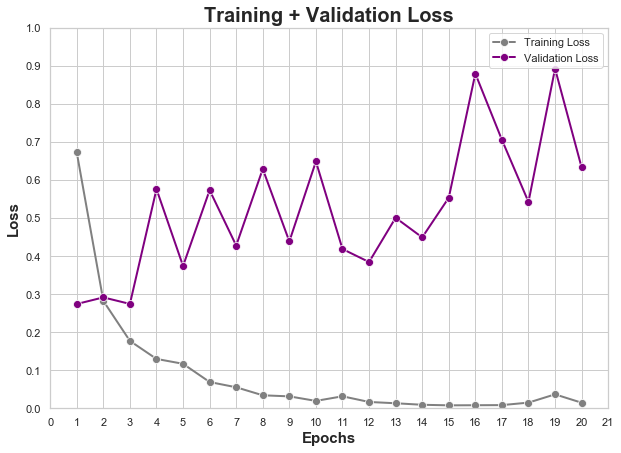

In [20]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
sns.lineplot(epochs, loss_values, label='Training Loss', linewidth=2, marker='o', markersize=8, color='grey')
sns.lineplot(epochs, val_loss_values, label='Validation Loss', linewidth=2, marker='o', markersize=8, color='purple')
plt.title('Training + Validation Loss', size=20, weight='bold')
plt.xlabel('Epochs', size=15, weight='bold')
plt.ylabel('Loss', size=15, weight='bold')
plt.axis([0,21,0,1])
plt.legend()
plt.show()
# plt.savefig('general_classification_cnn_loss.pdf')

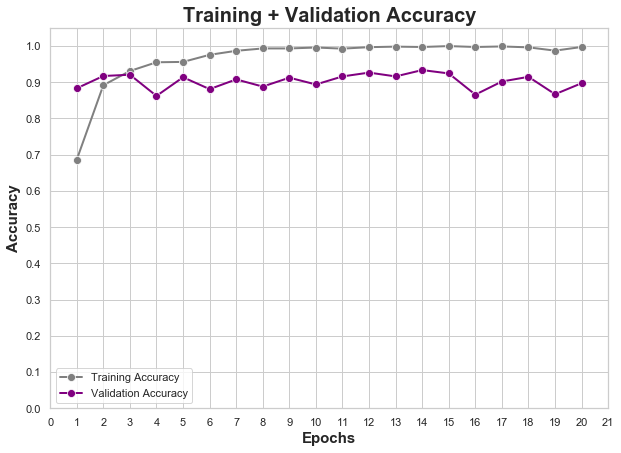

In [19]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
sns.lineplot(epochs, acc_values, label='Training Accuracy', linewidth=2, marker='o', markersize=8, color='grey')
sns.lineplot(epochs, val_acc_values, label='Validation Accuracy', linewidth=2, marker='o', markersize=8, color='purple')
plt.title('Training + Validation Accuracy', size=20, weight='bold')
plt.xlabel('Epochs', size=15, weight='bold')
plt.ylabel('Accuracy', size=15, weight='bold')
plt.axis([0,21,0,1.05])
plt.legend()
plt.show()
# plt.savefig('general_classification_cnn_accuracy.pdf')

## Try Only 3 Epochs

In [32]:
cnn_general_2 = models.Sequential() #instantiate model

cnn_general_2.add(cnn_base) #add InceptionResNetV2 pre-trained model without top

cnn_general_2.add(layers.Conv2D(64, (3, 3), #64 different filters, with a 3x3 filter.
                      activation='relu', #use ReLu activation functions throughout, save sigmoid / softmax function for the end layer.
                      input_shape=(256, 256,  3), #image shape input
                      padding='SAME')) #"valid" means no padding, and "same" means with padding.

# 64 bias parameters.
# 64 * (3 * 3 * 3) weight parametrs.
# Output is 64*256*256.

cnn_general_2.add(layers.MaxPooling2D((2, 2))) #(2,2) reduces dimensionality of image by half.

# Output is 64*128*128.
# 32 nodes in this layer...no padding here.
# Adding padding='SAME' here because InceptionResNetV2 downsamples the input image very aggressively...
# And we would otherwise get a negative dimension size in the next pooling step.
cnn_general_2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')) 

# 32 bias parameters.
# 32 * (3*3*64).
# Output is 32*128*128.

cnn_general_2.add(layers.MaxPooling2D((2, 2))) 

# Output is 32*64*64.
# Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# We flatten the output of the convolutional layers to create a single long feature vector. 
# 32 x 64 x 64 = 131,072 features once flattened.
cnn_general_2.add(layers.Flatten())

# And the flattened data is connected to the final classification, fully-connected layers.
# We simply put all the pixel data in one line and make connections with the final layer. 
# Dense fully connected layer.
cnn_general_2.add(layers.Dense(32, activation='relu')) 

# Final layer does the classification.
# A material cannot be both "not cracked" and "cracked" - it is either one or the other.
# So we use a "Softmax" function for classification where there is only 1 "right answer".
cnn_general_2.add(layers.Dense(2, activation='softmax')) 

In [33]:
#freeze the base_cnn model, and double-check to make sure it's frozen.
cnn_base.trainable = False
for layer in cnn_general_2.layers:
    print(layer.name, layer.trainable)

inception_resnet_v2 False
conv2d_208 True
max_pooling2d_9 True
conv2d_209 True
max_pooling2d_10 True
flatten_3 True
dense_5 True
dense_6 True


In [34]:
#try "adam" for optimizer instead of SGD - it combines the best properties of AdaGrad and RMSProp
cnn_general_2.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc'])

In [35]:
cnn_general_2_a = cnn_general_2.fit(X_train,
               y_train,
               epochs=3,
               workers=8,
               batch_size=100,
               validation_data=(X_validation, y_validation),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 1992 samples, validate on 855 samples
Epoch 1/3
1992/1992 [==============================] - 219s 110ms/step - loss: 0.7499 - acc: 0.6963 - val_loss: 0.2266 - val_acc: 0.9170
Epoch 2/3
1992/1992 [==============================] - 211s 106ms/step - loss: 0.2389 - acc: 0.9076 - val_loss: 0.3982 - val_acc: 0.8877
Epoch 3/3
1992/1992 [==============================] - 211s 106ms/step - loss: 0.1982 - acc: 0.9182 - val_loss: 0.2946 - val_acc: 0.9111


In [36]:
# Evaluate model on test data.
# Returns results in this format: [loss, accuracy]
cnn_general_2.evaluate(X_test, y_test)

712/712 [==============================] - 58s 81ms/step


[0.32649939833732133, 0.9044944047927856]

In [37]:
y_pred = cnn_general_2.predict(X_test)

___

## Analyze Prediction Probabilities

In [61]:
y_pred

array([[1.1181320e-02, 9.8881871e-01],
       [2.6941401e-01, 7.3058599e-01],
       [2.6828215e-05, 9.9997318e-01],
       ...,
       [1.0955712e-02, 9.8904431e-01],
       [2.3969974e-01, 7.6030028e-01],
       [1.0112081e-09, 1.0000000e+00]], dtype=float32)

In [62]:
pred_probs = []
for x in y_pred:
    pred_probs.append(x.max())

In [63]:
pred_probs

[0.9888187,
 0.730586,
 0.9999732,
 0.9841881,
 0.99932325,
 0.9883762,
 0.99988365,
 0.9999349,
 0.7783296,
 0.95534027,
 0.99215853,
 0.99989974,
 0.99999905,
 1.0,
 0.61019695,
 0.9999944,
 0.95333976,
 0.5397682,
 0.9999565,
 0.64601433,
 0.5198626,
 0.9999734,
 0.98143286,
 0.99998176,
 0.73673815,
 0.99998975,
 0.9999589,
 0.9986105,
 0.9999906,
 0.9995943,
 0.99952435,
 0.9943078,
 0.5811295,
 0.96169186,
 0.99999905,
 0.9996164,
 0.99933773,
 0.9998591,
 0.5703199,
 0.66965985,
 0.9999716,
 0.9944231,
 0.9999931,
 0.9931415,
 0.9999522,
 0.9978053,
 0.99918956,
 0.999689,
 0.97396404,
 0.99485564,
 0.99923635,
 0.68208027,
 0.9999925,
 0.9420365,
 0.99999225,
 0.99999905,
 0.9978132,
 0.9708528,
 0.99842846,
 0.93128425,
 0.996102,
 1.0,
 0.93461883,
 0.5521525,
 0.93733495,
 0.99999833,
 0.99942636,
 0.9999976,
 0.9988366,
 0.9999832,
 0.9999722,
 0.99991035,
 0.9997634,
 0.9991085,
 0.9947003,
 0.9999858,
 0.9999075,
 0.9876494,
 0.9898219,
 0.96226406,
 0.95973986,
 0.995506

In [82]:
pred_probs_90_plus = []
pred_probs_90_less = []
for x in pred_probs:
    if x >= .9:
        pred_probs_90_plus.append(x)
    else:
        pred_probs_90_less.append(x)

In [84]:
print(len(pred_probs_90_plus))
print(len(pred_probs_90_less))

623
89


In [88]:
len(pred_probs_90_plus)/(len(pred_probs_90_plus) + len(pred_probs_90_less))

0.875

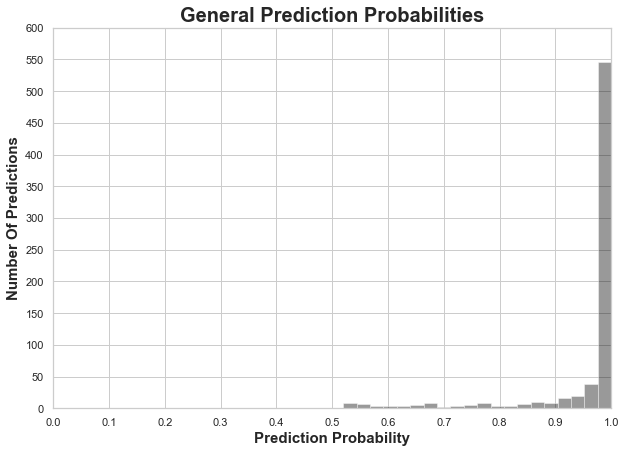

In [72]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
sns.distplot(pred_probs, kde=False, bins=20, color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('General Prediction Probabilities', size=20, weight='bold')
plt.xlabel('Prediction Probability', size=15, weight='bold')
plt.ylabel('Number Of Predictions', size=15, weight='bold')
plt.axis([0,1.0,0,600])
plt.show()
# plt.savefig('general_prediction_probabilities.pdf', dpi=300)

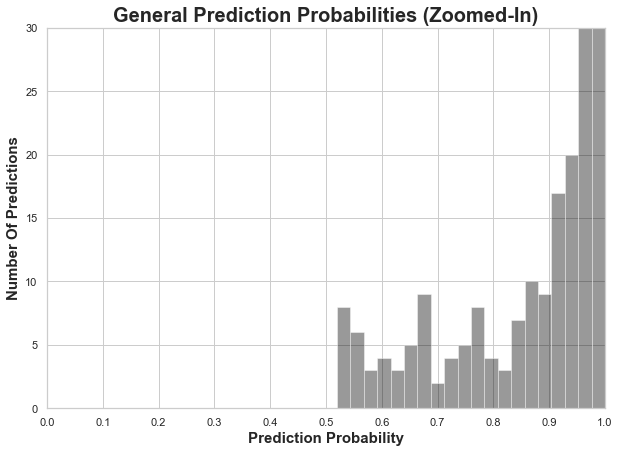

In [73]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
sns.distplot(pred_probs, kde=False, bins=20, color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('General Prediction Probabilities (Zoomed-In)', size=20, weight='bold')
plt.xlabel('Prediction Probability', size=15, weight='bold')
plt.ylabel('Number Of Predictions', size=15, weight='bold')
plt.axis([0,1.0,0,30])
plt.show()
# plt.savefig('general_prediction_probabilities_zoom.pdf', dpi=300)

___

## Confusion Matrix

In [45]:
conf_matrix_general = pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)),
    index = ['Actual General', 'Actual Specific'], 
    columns = ['Predicted General', 'Predicted Specific']
)
conf_matrix_general

,Predicted General,Predicted Specific
Actual General,168,62
Actual Specific,6,476


In [47]:
accuracy = []
precision = []
recall = []
f1 = []

accuracy.append((conf_matrix_general['Predicted General'][0] + conf_matrix_general['Predicted Specific'][1]) / (conf_matrix_general['Predicted General'].sum() + conf_matrix_general['Predicted Specific'].sum()))
precision.append(conf_matrix_general['Predicted General'][0] / (conf_matrix_general['Predicted General'][0] + conf_matrix_general['Predicted General'][1]))
recall.append(conf_matrix_general['Predicted General'][0] / (conf_matrix_general['Predicted General'][0] + conf_matrix_general['Predicted Specific'][0]))
f1.append(2 * ((precision[0] * recall[0]) / (precision[0] + recall[0])))

In [48]:
metrics_df = pd.DataFrame({'Accuracy': accuracy,
                           'Precision': precision, 
                           'Recall': recall, 
                           'F1': f1})
metrics_df

,Accuracy,Precision,Recall,F1
0,0.904494,0.965517,0.730435,0.831683


In [49]:
metrics_df = metrics_df.reset_index()

In [50]:
metrics_df_1 = pd.melt(metrics_df, id_vars=['index']).sort_values(['variable','value'])
metrics_df_1

,index,variable,value
0,0,Accuracy,0.904494
3,0,F1,0.831683
1,0,Precision,0.965517
2,0,Recall,0.730435


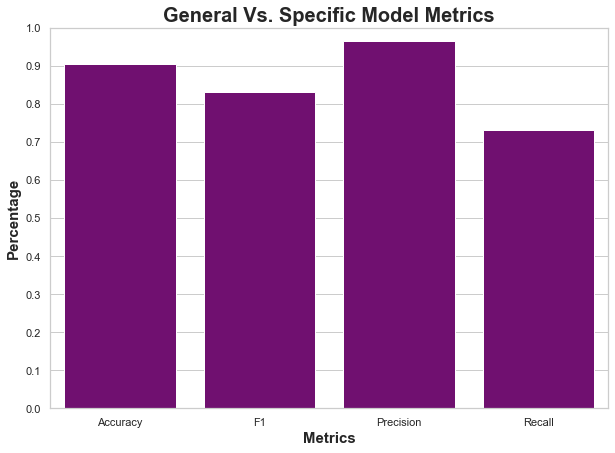

In [52]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.set(style='whitegrid', font_scale=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
sns.barplot(x='variable', y='value', data=metrics_df_1, color='purple')
plt.xticks(rotation=0)
plt.title('General Vs. Specific Model Metrics', size=20, weight='bold')
plt.xlabel('Metrics', size=15, weight='bold')
plt.ylabel('Percentage', size=15, weight='bold')
plt.ylim([0,1])
plt.show()
# plt.savefig('General_Classification_CNN_Model_Metrics.pdf', dpi=300)

___

## Predicting Images

In [53]:
sns.set(style='white')

In [54]:
classes = ['general', 'specific']

In [55]:
def predict_image_cnn(model, path):
    img = load_img(path, target_size=(256, 256))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    pred_name = classes[np.argmax(predict)]
    return predict.max(), pred_name

(0.9999796, 'general')

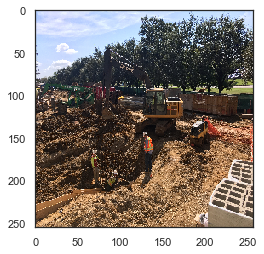

In [56]:
predict_image_cnn(
    cnn_general_2, 
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/General-Classification/General/General - 1,095.JPG')

(0.99940705, 'specific')

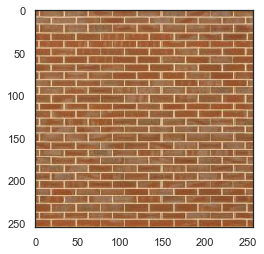

In [58]:
predict_image_cnn(
    cnn_general_2, 
    '/Users/alexandercheng/Desktop/code/projects/crack-detection-data/General-Classification/Specific/Brick - Not Cracked - 42.jpg')